In [2]:
import os

In [3]:
os.environ["OMP_NUM_THREADS"] = "20"
os.environ["MKL_NUM_THREADS"] = "20"

In [45]:
import pandas as pd
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from typing import Callable
from collections import defaultdict
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt

In [5]:
torch.set_num_threads(20)

In [6]:
import resource

memory_limit = 100 * 1024**3 # 100GB
resource.setrlimit(resource.RLIMIT_AS, (memory_limit, memory_limit))

In [20]:
df = pd.read_pickle('../data/012_recoded_X_full_ib_2025.pkl.gz')
df = df.iloc[:, -5000:]
df

,NC_024468.2:122397722,NC_024468.2:122397723,NC_024468.2:122406193,NC_024468.2:122406221,NC_024468.2:122406278,NC_024468.2:122407802,NC_024468.2:122478354,NC_024468.2:122478554,NC_024468.2:122505426,NC_024468.2:122510257,...,NC_024468.2:150831748,NC_024468.2:150832306,NC_024468.2:150847901,NC_024468.2:150847940,NC_024468.2:150898874,NC_024468.2:150898887,NC_024468.2:150898892,NC_024468.2:150911118,NC_024468.2:150911128,Heterotic group
0,0,0,0,0,0,0,2,0,2,0,...,0,0,0,0,0,0,0,0,0,NSS
1,1,1,0,2,0,2,2,1,2,0,...,1,1,2,0,2,2,2,0,0,SPT
2,0,0,1,0,0,0,2,0,2,1,...,1,0,0,0,1,1,1,1,1,NSS
3,0,0,0,0,0,0,0,0,2,2,...,0,0,0,0,0,0,0,0,0,PB
4,0,0,0,0,0,0,2,0,2,0,...,2,2,2,1,2,2,2,1,1,PA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,1,1,PA
601,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,PA
602,0,0,0,0,0,0,2,0,2,0,...,0,2,2,0,2,2,2,1,1,PA
603,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,PA


In [21]:
X = df.drop(columns=["Heterotic group"])
y = df["Heterotic group"]

In [22]:
X

,NC_024468.2:122397722,NC_024468.2:122397723,NC_024468.2:122406193,NC_024468.2:122406221,NC_024468.2:122406278,NC_024468.2:122407802,NC_024468.2:122478354,NC_024468.2:122478554,NC_024468.2:122505426,NC_024468.2:122510257,...,NC_024468.2:150828874,NC_024468.2:150831748,NC_024468.2:150832306,NC_024468.2:150847901,NC_024468.2:150847940,NC_024468.2:150898874,NC_024468.2:150898887,NC_024468.2:150898892,NC_024468.2:150911118,NC_024468.2:150911128
0,0,0,0,0,0,0,2,0,2,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,2,0,2,2,1,2,0,...,2,1,1,2,0,2,2,2,0,0
2,0,0,1,0,0,0,2,0,2,1,...,0,1,0,0,0,1,1,1,1,1
3,0,0,0,0,0,0,0,0,2,2,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,2,0,2,0,...,1,2,2,2,1,2,2,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,1
601,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
602,0,0,0,0,0,0,2,0,2,0,...,2,0,2,2,0,2,2,2,1,1
603,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


In [23]:
y

0      NSS
1      SPT
2      NSS
3       PB
4       PA
      ... 
600     PA
601     PA
602     PA
603     PA
604    NSS
Name: Heterotic group, Length: 604, dtype: object

Инициализация тензора из датафрейма с SNP

In [24]:
np_array = np.array(X)
x_np = torch.from_numpy(np_array)

In [37]:
x_np.shape[1]

4999

Инициализация тензора из таргетной переменной (предварительно перекодировали в числа). Норм, что не onehot?

In [26]:
codes, uniques = pd.factorize(y)
np_array_y = np.array(codes)
y_np = torch.from_numpy(np_array_y)


In [27]:
y_np.shape

torch.Size([604])

Деление на train и test и Создание DataLoader

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_np, y_np, test_size=0.2, random_state=42)


train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

Определяем архитектуру

In [38]:
class CNNet(nn.Module):
    def __init__(self, input_dim=x_np.shape[1], num_classes=7, dropout_prob=0.6):
        super().__init__()
        self.hidden1 = input_dim * 3 // 4  
        self.hidden2 = input_dim // 2
        self.compress1 = nn.Linear(input_dim, self.hidden1)
        self.compress2 = nn.Linear(self.hidden1, self.hidden2)
        self.bn1 = nn.BatchNorm1d(self.hidden1)
        self.bn2 = nn.BatchNorm1d(self.hidden2)
        self.dropout = nn.Dropout(p=dropout_prob)
        self.classifier = nn.Linear(self.hidden2, num_classes)

    def forward(self, x):
        x = self.compress1(x)              # 1-е сжатие, без активации релу
        x = self.bn1(x)                    #BatchNorm1d
        x = F.relu(x)                       # активация релу
        x = self.compress2(x)              # 2-е сжатие
        x = self.bn2(x)                    #BatchNorm1d
        x = F.relu(x)                      # активация релу
        x = self.dropout(x)                # регуляризация
        x = self.classifier(x)             # классификация
        return x
    

Функции для запуска обучения

In [39]:
def training_step(
    batch: tuple[torch.Tensor, torch.Tensor],
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    device: str = "cpu",
) -> tuple[Tensor, Tensor]:
    model.to(device=device)
    x, y = batch
    logits = model(x.to(device=device).float())
    loss = F.cross_entropy(logits, y.to(device=device))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss, logits



def train_epoch(
    dataloader: DataLoader,
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    device: str = "cpu",
) -> dict[str, float]:
    model.train()
    loss_total = 0
    n_total = 0
    all_preds = []
    all_labels = []

    for i, batch in enumerate(dataloader):
        x, y = batch
        loss, logits = training_step(batch, model, optimizer, device)

      
        n_total += y.size(0)
        loss_total += y.size(0) * loss.item()

       
        preds = logits.argmax(dim=1).cpu().numpy()  
        labels = y.cpu().numpy() 

        all_preds.extend(preds)
        all_labels.extend(labels)

    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=1)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=1)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=1)


    accuracy = accuracy_score(all_labels, all_preds)

    return {
        "loss": loss_total / n_total,
        "accuracy": accuracy, 
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }


from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

@torch.no_grad()
def test_epoch(
    dataloader: DataLoader,
    model: nn.Module,
    device: str = "cpu",
) -> dict[str, float]:
    model.eval()
    model.to(device=device)
    loss_total = 0
    n_total = 0
    all_preds = []
    all_labels = []

    for i, batch in enumerate(dataloader):
        x, y = batch
        logits = model(x.to(device=device).float())
     
        loss = F.cross_entropy(logits, y.to(device=device))
  
        n_total += y.size(0)

        loss_total += y.size(0) * loss.item()

    
        preds = logits.argmax(dim=1).cpu().numpy()  
        labels = y.cpu().numpy()  

        all_preds.extend(preds)
        all_labels.extend(labels)


    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=1)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=1)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=1)


    accuracy = accuracy_score(all_labels, all_preds)

    return {
        "loss": loss_total / n_total,
        "accuracy": accuracy,  
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }



def run_experiment(
    model_gen: Callable[[], nn.Module],
    optim_gen: Callable[[nn.Module], torch.optim.Optimizer],
    seed: int,
    n_epochs: int = 10,
    verbose: bool = False,
    device: str = "cpu",
) -> dict[str, list[float]]:
    """Функция для запуска экспериментов.

    Args:
        model_gen (Callable[[], nn.Module]): Функция для создания модели
        optim_gen (Callable[[nn.Module], torch.optim.Optimizer]): Функция для создания оптимизатора для модели
        seed (int): random seed
        n_epochs (int, optional): Число эпох обучения. Defaults to 10.
        verbose (bool, optional): Выводить ли информацию для отладки. Defaults to False.

    Returns:
        tuple[list[float], list[float]]: Значения ошибки на обучающей и тестовой выборках по всем эпохам
    """
    torch.manual_seed(seed)
    model = model_gen()
    optim = optim_gen(model)
    metrics: dict[str, list[float]] = defaultdict(list)

    for i in range(n_epochs):
    
        train_dict = train_epoch(
            train_loader, model, optim, device=device
        )
    
        test_dict = test_epoch(
         test_loader, model, device=device
        )
    
  
        train_loss, train_accuracy = train_dict["loss"], train_dict["accuracy"]
        test_loss, test_accuracy = test_dict["loss"], test_dict["accuracy"]
        train_precision, train_recall, train_f1 = train_dict["precision"], train_dict["recall"], train_dict["f1"]
        test_precision, test_recall, test_f1 = test_dict["precision"], test_dict["recall"], test_dict["f1"]
    
   
        if verbose:
            print(f"Epoch {i} train: loss = {train_loss:.4f}, accuracy = {train_accuracy:.4f}, "
                f"precision = {train_precision:.4f}, recall = {train_recall:.4f}, f1 = {train_f1:.4f}")
            print(f"Epoch {i} test: loss = {test_loss:.4f}, accuracy = {test_accuracy:.4f}, "
                f"precision = {test_precision:.4f}, recall = {test_recall:.4f}, f1 = {test_f1:.4f}")
    

        metrics["train_losses"].append(train_loss)
        metrics["train_accuracies"].append(train_accuracy)
        metrics["train_precisions"].append(train_precision)
        metrics["train_recalls"].append(train_recall)
        metrics["train_f1s"].append(train_f1)
    
        metrics["test_losses"].append(test_loss)
        metrics["test_accuracies"].append(test_accuracy)
        metrics["test_precisions"].append(test_precision)
        metrics["test_recalls"].append(test_recall)
        metrics["test_f1s"].append(test_f1)


    return metrics


In [46]:
metrics_dict = run_experiment(
    model_gen=lambda: CNNet(),
    optim_gen=lambda x: torch.optim.Adam(x.parameters(), lr=0.001, weight_decay=1e-4),
    seed=42,
    n_epochs=10,
    verbose=True,
    device="cpu",
)

Epoch 0 train: loss = 1.3706, accuracy = 0.5983, precision = 0.6000, recall = 0.5983, f1 = 0.5967
Epoch 0 test: loss = 3.0219, accuracy = 0.5950, precision = 0.7571, recall = 0.5950, f1 = 0.5859
Epoch 1 train: loss = 0.5513, accuracy = 0.8199, precision = 0.8172, recall = 0.8199, f1 = 0.8170
Epoch 1 test: loss = 1.3857, accuracy = 0.7190, precision = 0.6724, recall = 0.7190, f1 = 0.6895
Epoch 2 train: loss = 0.3906, accuracy = 0.8799, precision = 0.8785, recall = 0.8799, f1 = 0.8771
Epoch 2 test: loss = 1.1468, accuracy = 0.7521, precision = 0.7099, recall = 0.7521, f1 = 0.7252
Epoch 3 train: loss = 0.2650, accuracy = 0.9213, precision = 0.9214, recall = 0.9213, f1 = 0.9208
Epoch 3 test: loss = 1.0561, accuracy = 0.7438, precision = 0.7349, recall = 0.7438, f1 = 0.7254
Epoch 4 train: loss = 0.1791, accuracy = 0.9462, precision = 0.9466, recall = 0.9462, f1 = 0.9456
Epoch 4 test: loss = 1.0983, accuracy = 0.7438, precision = 0.7047, recall = 0.7438, f1 = 0.7178
Epoch 5 train: loss = 0.1

In [43]:
def create_report(metrics: dict[str, list[float]]) -> None:
    """Функция для создания мини-отчёта об обучении модели.

    Args:
        metrics (dict[str, list[float]]): Словарь с метриками, выход из `run_experiment`.
    """
    print(f'Минимальная ошибка:        {min(metrics["test_losses"]):.4f}')
    print(f'Максимальная точность:     {max(metrics["test_accuracies"]):.4f}')
    print()
    print(f'Ошибка в конце обучения:   {metrics["test_losses"][-1]:.4f}')
    print(f'Точность в конце обучения: {metrics["test_accuracies"][-1]:.4f}')
    fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(12, 2.5))

    loss_ax.set_title("Loss")
    loss_ax.plot(metrics["train_losses"])
    loss_ax.plot(metrics["test_losses"])
    loss_ax.legend(("train", "test"), loc="upper right")

    acc_ax.set_title("Accuracy")
    acc_ax.plot(metrics["train_accuracies"])
    acc_ax.plot(metrics["test_accuracies"])
    acc_ax.legend(("train", "test"), loc="upper right")
    plt.show()



Минимальная ошибка:        1.0561
Максимальная точность:     0.7603

Ошибка в конце обучения:   1.2194
Точность в конце обучения: 0.7603


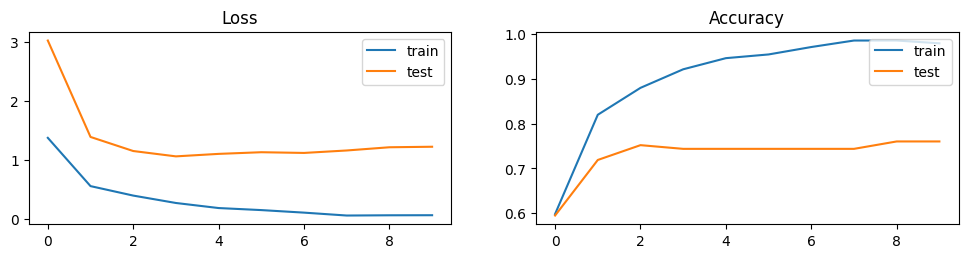

In [47]:
create_report(metrics_dict)